## Research data supporting "omputational Discovery of a Copper Phosphide Conversion Anode for Lithium-Ion Batteries"

This notebook can be found on GitHub at https://github.com/harpaf13/data.copper-phosphides with a requirements file and description.

### Abstract

Using first principles structure searching with density-functional theory (DFT) we identify a novel $Fm\bar{3}m$ phase of Cu$_2$P and two low-lying metastable structures, an $I\bar{4}3d$--Cu$_3$P phase, and a $Cm$--Cu$_3$P$_{11}$ phase. The computed pair distribution function of the novel $Cm$--Cu$_3$P$_{11}$ phase shows its structural similarity to the experimentally identified $Cm$--Cu$_2$P$_7$ phase. The relative stability of all Cu--P phases at finite temperatures is determined by calculating the Gibbs free energy using vibrational effects from phonon modes at 0\,K. From this, a finite-temperature convex hull is created, on which $Fm\bar{3}m$--Cu$_2$P is dynamically stable and the Cu$_{3-x}$P ($x < 1$) defect phase $Cmc2_1$--Cu$_8$P$_3$ remains metastable (within 20\,meV/atom of the convex hull) across a temperature range from 0\,K to 600\,K. Both CuP$_2$ and Cu$_3$P exhibit theoretical gravimetric capacities higher than contemporary graphite anodes for Li-ion batteries; the predicted Cu$_2$P phase has a theoretical gravimetric capacity of 508\,mAh/g as a Li-ion battery electrode, greater than both Cu$_3$P (363\,mAh/g) and graphite (372\,mAh/g). Cu$_2$P is also predicted to be both non-magnetic and metallic, which should promote efficient electron transfer in the anode. Cu$_2$P's favorable properties as a metallic, high-capacity material suggest its use as a future conversion anode for Li-ion batteries; with a volume expansion of 99\,\% during complete cycling, Cu$_2$P anodes could be more durable than other conversion anodes in the Cu--P system with volume expansions greater than 150\,\%. 

### Imports

In [1]:
import tqdm
import glob
import pickle

import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline

from matador.config.config import set_settings
set_settings(
    {
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/CuP.mplstyle']
        }
    }
)
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict, bands2dict
from matador.utils.cursor_utils import filter_unique_structures, display_results
from matador.crystal import Crystal
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg, get_space_group_label_latex
from matador.utils.chem_utils import get_formula_from_stoich
from matador.hull.hull_temperature import TemperatureDependentHull 
from matador.orm.spectral import VibrationalDOS, ElectronicDispersion
import matador.plotting

### Download and extract data from repository

In [2]:
def download_and_extract(url, fname):
    import urllib
    import tarfile
    if url is None:
        raise RuntimeError("Data not yet available.")
    response = urllib.request.urlretrieve(url, fname)
    tar = tarfile.open(fname)
    tar.extractall('.')

# once the data has been archived and released, this function can be used to download and extract it
url = None
fname = "HarperCuPData.tar.gz"
download_and_extract(url, fname)

RuntimeError: Data not yet available.

## Results

### Convex hull from structure prediction

In [3]:
# load AIRSS structures obtained from searching
cursor, failures = res2dict('HarperCuPData/CuPHull/*.res', as_model=True)

Successfully scraped 240 out of 240 files.


In [4]:
# filter for uniqueness
filtering = True
if filtering:
    polished_cursor = filter_unique_structures(cursor, sim_tol=0.1, enforce_same_stoich=True, quiet=True)
else:
    polished_cursor = cursor

# do some pruning: reevaluate symmetries and reduce cells
polished_cursor = [Crystal(standardize_doc_cell(doc)) for doc in polished_cursor]

Calculating fingerprints...
Assessing similarities...
Skipping 13 structures out of 240 as no comparisons are required
Running 227 jobs on at most 6 processes, set by core count.
Applying hierarchy of structures with order: ['ICSD', 'DOI', 'OQMD', 'MP', 'PF', 'SWAPS', 'AIRSS', 'GA']
Done!
Filtered 240 down to 42


In [5]:
polished_hull = QueryConvexHull(
    cursor=polished_cursor, 
    species='CuP',
    no_plot=True,
    hull_cutoff=0.02,
)

10 structures found within 0.02 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0               -0.09         11.9           0.0           Fm-3m           Cu          1      ICSD  
  Cu3P-swap-AsCu3-OQMD_11878-Col[..]           -0.04         52.5          10.8           I-43d          Cu3P         8     SWAPS  
  Cu3P-config_enum_65                          -0.07        146.0          18.5          Cmc2_1          Cu8P3        2      ENUM  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]       

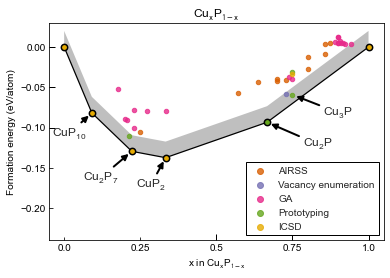

In [6]:
# Plot the convex hull of the 44 structures from filtering
fig, ax = plt.subplots()
polished_hull.hull_cutoff = 0 #This allows us to then add the color shading up to the 0.02 cutoff
ax = matador.plotting.plot_2d_hull(
    polished_hull,
    ax=ax,
    label_cutoff=0.012, 
    colour_by_source=True,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.24, 0.03),
    sources=['AIRSS', 'ENUM', 'GA', 'SWAPS', 'ICSD', 'OQMD'],
    source_labels=['AIRSS', 'Vacancy enumeration', 'GA', 'Prototyping', 'ICSD', 'OQMD']
)
#plot up to 20 meV/atom with gray shading
tie_line = polished_hull.convex_hull.points[polished_hull.convex_hull.vertices]
hull_cutoff = 0.02
ax.fill_between(np.sort(tie_line[:, 0]), tie_line[np.argsort(tie_line[:, 0]), 1], 
                tie_line[np.argsort(tie_line[:, 0]), 1] + hull_cutoff,
                facecolor='gray', alpha=0.5)

ax.set_yticks([-0.2, -0.15, -0.1, -0.05, 0.0])
ax.tick_params(direction='in')
ax.legend(loc='lower right')
plt.savefig('CuP-convex-hull.pdf', bbox_inches='tight')

In [7]:
# Print a table of all the structures with negative formation energy which are also within 50 meV of hull
# currently "summary" means it takes the best structure at each stoich
table_args = {'hull': True, 'summary': False,'use_source': True}

table_cursor = [doc for doc in polished_hull.cursor if doc['hull_distance'] <= 0.05 and doc['formation_enthalpy'] <= 0]
display_results(table_cursor, **table_args)
latex_table = display_results(table_cursor, latex=True, return_str=True, **table_args)

# Replace caps "SWAPS" with "swaps"
latex_table = latex_table.replace("SWAPS", "swaps")
with open('CuP_table.tex', 'w') as f:
    f.write(latex_table)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0               -0.09         11.9           0.0           Fm-3m           Cu          1      ICSD  
  CuP_ratios-anbf0m                            -0.02         44.7          31.3          I4/mmm          Cu6P         2     AIRSS  
  CuP_ratios-kzw2ky                            -0.05         65.6          28.2          P4/nmm          Cu4P         2     AIRSS  
  CuP_ratios-9pvghx                             0.02         65.5          44.1           Amm2           Cu4P         1   

### Structural similarity between CuP$_2$, Cu$_3$P$_{11}$ and Cu$_2$P$_7$

Successfully scraped 3 out of 3 files.


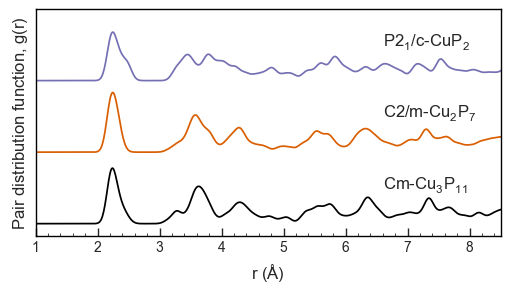

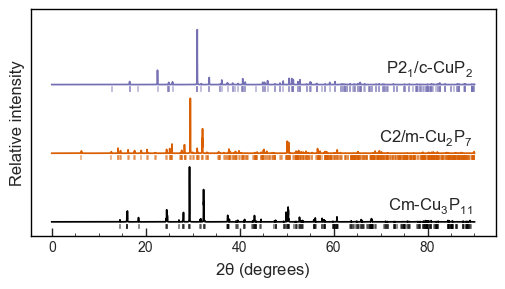

In [8]:
cursor, failures = res2dict('HarperCuPData/Cu3P11-Cu2P7-CuP2/*.res', as_model=True)

plot_order = ['Cu3P11', 'Cu2P7', 'CuP2']
cursor = sorted(cursor, key=lambda x: plot_order.index(x.formula))

matador.plotting.plot_pdf(
    cursor, 
    text_offset=(6.6, 0.60),
    r_max=8, 
    r_min=1,
    pdf=True,
    filename="Cu3P11-Cu2P7-CuP2-pdf"
)
matador.plotting.plot_pxrd(
    cursor, 
    text_offset=0.18,
    rug=True,
    rug_offset=0.04,
    pdf=True,
    filename="Cu3P11-Cu2P7-CuP2-pxrd"
)

### Cu$_2$P electronic structure and dynamic stability

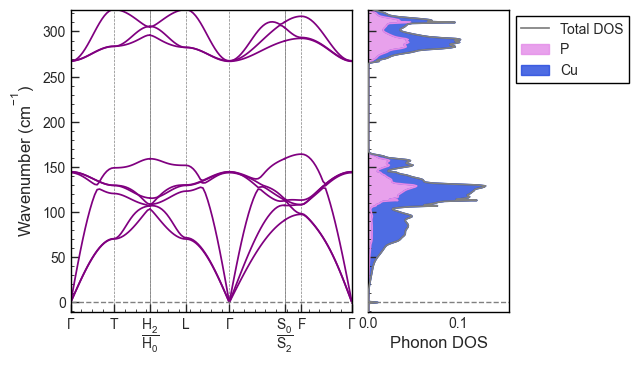

In [9]:
ax = matador.plotting.plot_spectral(
    'HarperCuPData/Cu2P/phonon/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple',
    figsize=(7, 4),
    pdf=True,
    filename='Cu2P_phonons'
)

Unable to create spglib structure from input data: skipping path labels: Unable to use doc2spg, one of ('lattice_cart', 'positions_frac', 'atom_types') was missing..


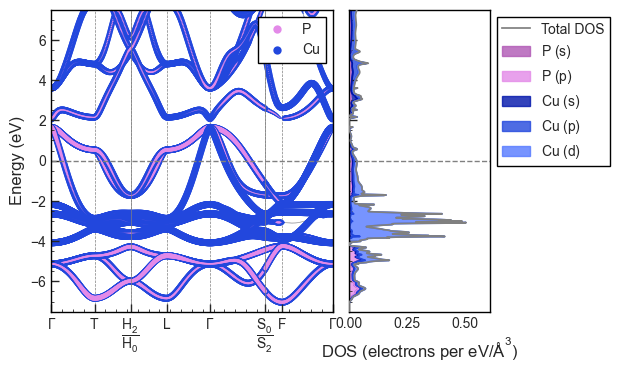

In [10]:
matador.plotting.plot_spectral(
    'HarperCuPData/Cu2P/bandstructure/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
    pdf=True,
    figsize=(7, 4),
    filename="Cu2P_bandstructure",
    plot_window=[-7.5,7.5]
)

### Finite temperature stability

Successfully scraped 9 out of 9 files.


100%|██████████| 21/21 [00:00<00:00, 835.05it/s]

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                  0.01         11.9           0.0           Fm-3m           Cu          1      ICSD  
* CuP-Ir2P-OQMD_30622-CollCode640898            0.01         41.6           0.0           Fm-3m          Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_0               -0.00        391.9           0.0          P2_1/c          CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0            

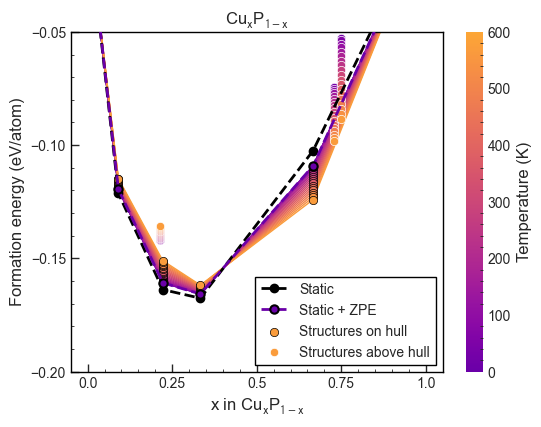

In [11]:
cursor, failures = castep2dict('HarperCuPData/TDHull/*.castep', db=False)
if failures:
    print(failures)
td_hull = TemperatureDependentHull(
    temperatures=np.linspace(0, 600, 21),
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P'],
    show=False
)

ax = td_hull.plot_hull(
    plot_points=True,
    show=False,
)
ax.set_yticks([-0.2, -0.15, -0.1, -0.05, 0.0])
lims = ax.get_ylim()
ax.set_ylim(-0.2, -0.05)
plt.savefig('CuPtemperature_hull.pdf', bbox_inches='tight')

### Temperature vs. Hull Distance for metastable structures

In [12]:
cursor, failures = castep2dict('HarperCuPData/TDHull/*.castep', db=False)
cursor.append(
    castep2dict('HarperCuPData/TDHull/Cu3P-I43d/*.castep', db=False)[0])
if failures:
    print(failures)
    
temperatures = np.linspace(0, 600, 51)
td_hull = TemperatureDependentHull(
    temperatures=temperatures,
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P'],
)

Successfully scraped 9 out of 9 files.


100%|██████████| 51/51 [00:00<00:00, 935.28it/s]

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                  0.01         11.9           0.0           Fm-3m           Cu          1      ICSD  
* CuP-Ir2P-OQMD_30622-CollCode640898            0.01         41.6           0.0           Fm-3m          Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_0               -0.00        391.9           0.0          P2_1/c          CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0            

Successfully scraped 5 out of 5 files.


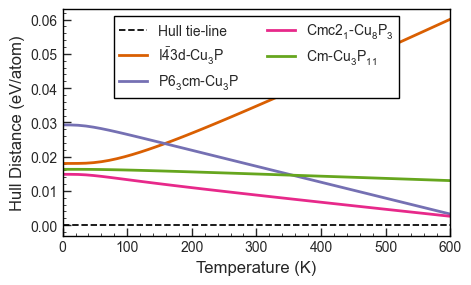

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
rescursor, failures = res2dict('HarperCuPData/TDHull/*.res', as_model=True)

lines = []
structs_to_plot = ['Cu3P','Cu8P3','Cu3P11']
lines += ax.plot([0, 600], [0, 0], label='Hull tie-line', linestyle='--')

for doc in td_hull.cursor:
    if get_formula_from_stoich(doc['stoichiometry']) in structs_to_plot:
        for resdoc in rescursor:
            if doc['source'][0].split('/')[-1].split('.')[0] == resdoc.root_source:
                sg = get_space_group_label_latex(get_spacegroup_spg(resdoc))
                
        lines += ax.plot(
            doc['temperature']['temperatures'], 
            doc['temperature']['hull_distance'],
            label=sg + '-' + get_formula_from_stoich(doc['stoichiometry'], tex=True),
            lw=2,
        )

ax.legend(ncol=2, loc='upper center')
ax.set_ylabel('Hull Distance (eV/atom)')
ax.set_xlabel('Temperature (K)')
ax.set_xlim(0, 600)

plt.savefig('CuPtemperature_vs_dist.pdf', bbox_inches='tight')

### Li-Cu-P ternary

In [14]:
cursor, failures = res2dict('HarperCuPData/VoltageCurve/*.res', as_model=True)
if failures:
    print(failures)
    
ternary_hull = QueryConvexHull(cursor=cursor,
        no_plot=True,
        volume=True,
        voltage=True,
        pdf=True,
        efmap=True,
        elements=['Li', 'Cu', 'P'],
)

Successfully scraped 17 out of 17 files.
14 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                  0.03         11.9           0.0           Fm-3m           Cu          1      ICSD  
* CuP-Ir2P-OQMD_30622-CollCode640898           -0.00         41.6           0.0           Fm-3m          Cu2P         1     SWAPS  
* Cu2LiP2-OQMD_2275-CollCode2734                0.01         72.5           0.0          I4/mmm         Cu2LiP2       1      ICSD  
* C

Wrote LiCuP_volume.pdf


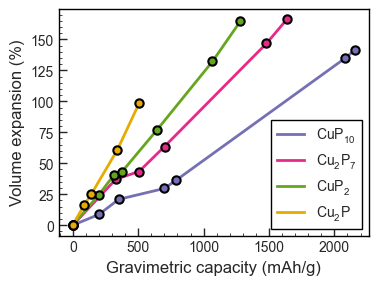

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))
matador.plotting.plot_volume_curve(ternary_hull, ax=ax, as_percentages=True)

Plotting ternary hull...
Wrote LiCuP_hull.pdf


TernaryAxesSubplot: 8739967968176

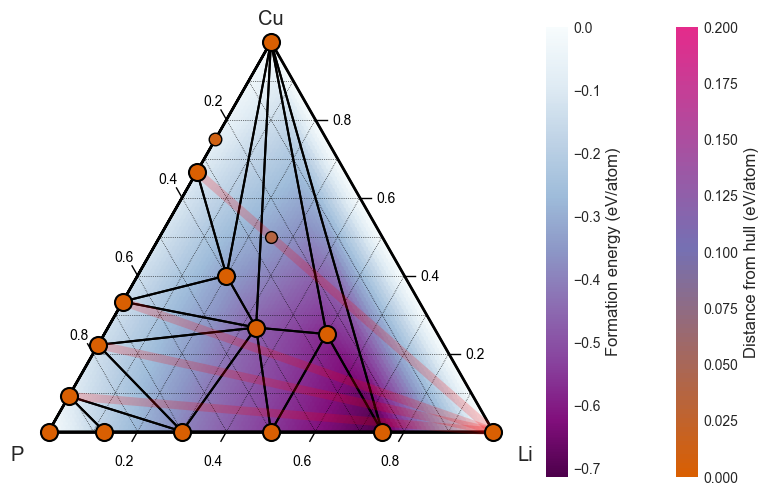

In [16]:
matador.plotting.plot_ternary_hull(
    ternary_hull, efmap=True, pdf=True, pathways=True, fig_height=8
)

In [17]:
# remove I43d Cu3P from cursor and plot with the ICSD P63cm Cu3P
cursor, failures = res2dict('HarperCuPData/VoltageCurve/*.res', as_model=True)
noI43dCu3P = [doc for doc in cursor if doc.formula == 'Cu3P' or doc.elems != ["Cu", "P"]]
noI43dCu3P = [doc for doc in noI43dCu3P if doc.root_source != 'Cu3P-swap-AsCu3-OQMD_11878-CollCode64715']
        
hullnoI43dCu3P = QueryConvexHull(
    cursor=noI43dCu3P,
    no_plot=True,
    voltage=True,
    volume=True,
    elements=['Li', 'Cu', 'P'],
)

Successfully scraped 17 out of 17 files.
11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                  0.03         11.9           0.0           Fm-3m           Cu          1      ICSD  
* Cu3P-OQMD_2966-CollCode15056-OTF             -0.07         50.7           0.0          P6_3cm          Cu3P         6     SWAPS  
* Cu2LiP2-OQMD_2275-CollCode2734                0.01         72.5           0.0          I4/mmm         Cu2LiP2       1      ICSD  
* C

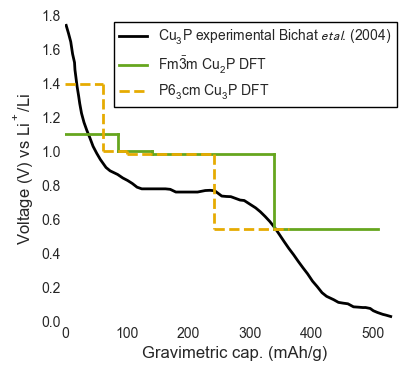

In [18]:
fig, ax = plt.subplots(figsize=(4, 3.5))

profiles_to_plot = (
    [profile for profile in ternary_hull.voltage_data if profile.starting_formula == "Cu2P"] + 
    [profile for profile in hullnoI43dCu3P.voltage_data if profile.starting_formula == "Cu3P"]
)
curve_labels= [r'$Fm\bar{3}m$ Cu$_2$P DFT', '$P6_3cm$ Cu$_3$P DFT']
line_kwargs = [{'ls': '-', 'c': '#66a61e'}, {'ls': '--', 'c': '#e6ab02'}]

ax = matador.plotting.plot_voltage_curve(
    profiles_to_plot,
    ax=ax,
    expt='HarperCuPData/VoltageCurve/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
    expt_label='Cu$_3$P experimental Bichat $\mathit{et\,al}$. (2004)',
    show=False,
    curve_labels=curve_labels,
    line_kwargs=line_kwargs
)

ax.set_xlim(0, 550)
ax.set_ylim(0, 1.8)
bbox_props = dict(facecolor='white', alpha=0.8)
font_props = fontdict={'family': 'serif'}
plt.savefig('Cu2PCu3P_voltage.pdf', bbox_inches='tight')

### Supplementary Information

### Structural Similarity of Cu$_2$P and Cu$_3$P phases

Successfully scraped 4 out of 4 files.


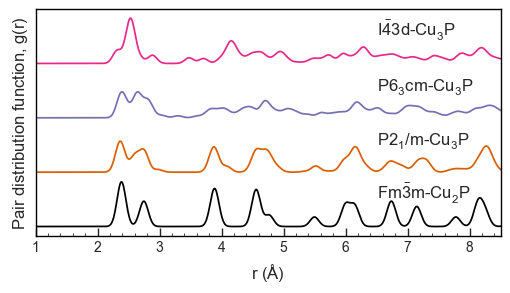

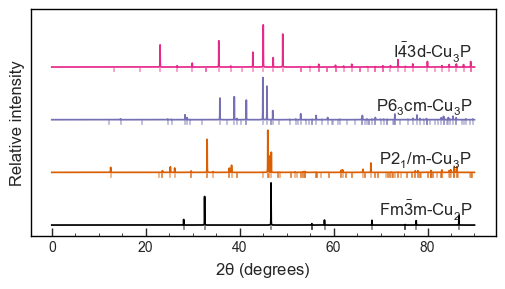

In [19]:
cursor, failures = res2dict('HarperCuPData/Cu2P-Cu3P-phases/*.res', as_model=True)
cursor = ([doc for doc in cursor if doc.formula == "Cu2P"] + 
          [doc for doc in cursor if not doc.formula == "Cu2P" and "m0ol1y" in doc.root_source] +
          [doc for doc in cursor if not doc.formula == "Cu2P" and "m0ol1y" not in doc.root_source])

matador.plotting.plot_pdf(
    cursor,
    text_offset=(6.5, 0.62),
    pdf=True,
    filename="Cu2P-Cu3P-pxrd",
    r_max=8,
    r_min=1,
)

matador.plotting.plot_pxrd(
    cursor,
    text_offset=0.18,
    pdf=True,
    filename="Cu2P-Cu3P-pdf",
    rug=True,
    rug_offset=0.03
)

### Structural Similarity of Cu$_2$P, Ir$_2$P and Rh$_2$P phases

Successfully scraped 3 out of 3 files.


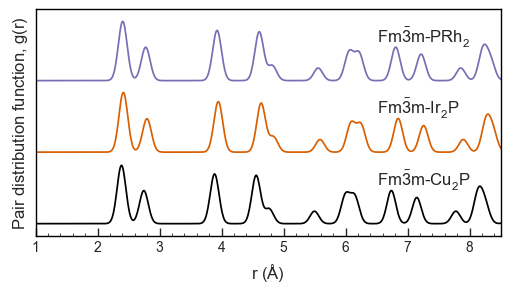

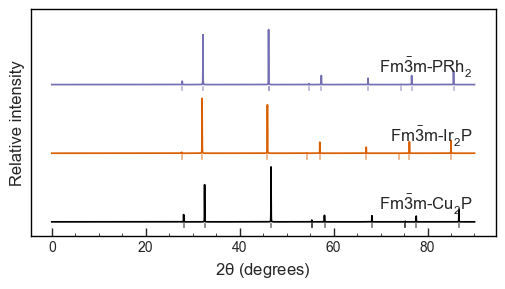

In [20]:
cursor, failures = res2dict('HarperCuPData/Cu2P-Ir2P-Rh2P-phases/*.res', as_model=True)
cursor = ([doc for doc in cursor if not doc.formula != 'Cu2P'] + 
          [doc for doc in cursor if not doc.formula == 'Cu2P'])

matador.plotting.plot_pdf(
    cursor,
    text_offset=(6.5, 0.65),
    filename="Cu2P-Ir2P-Rh2P-pdf",
    pdf=True,
    r_max=8,
    r_min=1,
)

matador.plotting.plot_pxrd(
    cursor,
    text_offset=0.18,
    pdf=True,
    filename="Cu2P-Ir2P-Rh2P-pxrd",
    rug=True,
    rug_offset=0.03
)

### Electronic structure of Cu$_2$P

#### HSE06 Hybrid Functional Cu$_2$P Electronic Band Structure

Disabling projections as mutiple seeds requested.
Unable to create spglib structure from input data: skipping path labels: Unable to use doc2spg, one of ('lattice_cart', 'positions_frac', 'atom_types') was missing..


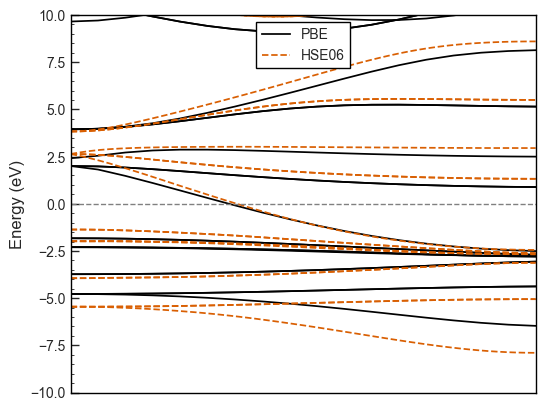

In [23]:
# HSE vs PBE comparison from Γ->T
bands, _ = bands2dict('HarperCuPData/Cu2P/bandstructure/CuP-Ir2P-OQMD_30622-CollCode640898.bands')
Cu2P_PBE_BS = ElectronicDispersion(bands).new_from_trimmed_path(0, 18)
bands, _ = bands2dict('HarperCuPData/Cu2P/bandstructure/HSE06/CuP-Ir2P-OQMD_30622-CollCode640898.bands')
Cu2P_HSE_BS = ElectronicDispersion(bands)
bands, _ = bands2dict('HarperCuPData/Cu2P/bandstructure/SCAN/CuP-Ir2P-OQMD_30622-CollCode640898.bands')
Cu2P_SCAN_BS = ElectronicDispersion(bands)

Cu2P_SCAN_BS._data['eigs_s_k'] = Cu2P_SCAN_BS._data['eigs_s_k'] + 0.35
Cu2P_PBE_BS._data['eigs_s_k'] = Cu2P_PBE_BS._data['eigs_s_k'] + 0.35
matador.plotting.plot_spectral(
    [Cu2P_PBE_BS, Cu2P_HSE_BS, Cu2P_SCAN_BS], 
    labels=['PBE', 'HSE06','SCAN'], 
    plot_dos=False,
    filename="Cu2P_HSE_SCAN_BS",
    pdf=True,
    figsize=(6, 5),
    plot_window=[-7.5,7.5]
)

#### PBE Spin-Polarized Electronic Density of States for Cu$_2$P

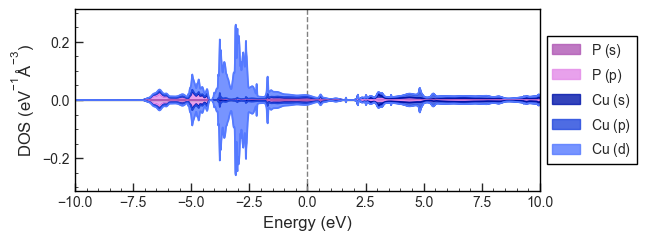

In [24]:
matador.plotting.plot_spectral(
    'HarperCuPData/Cu2P/bandstructure/SPIN/CuP-Ir2P-OQMD_30622-CollCode640898',
    plot_bandstructure=False,
    pdf=True,
    figsize=(6, 2.4),
    filename="Cu2P_SPIN_BS"
)

#### Spin-Orbit Coupled Electronic Density of States for Cu$_2$P, Ir$_2$P, and Rh$_2$P

Unable to create spglib structure from input data: skipping path labels: Unable to use doc2spg, one of ('lattice_cart', 'positions_frac', 'atom_types') was missing..


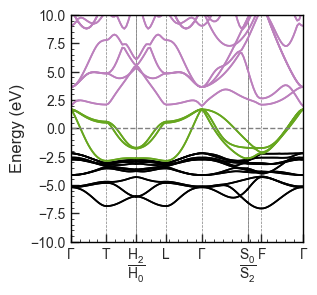

In [25]:
matador.plotting.plot_spectral(
    'HarperCuPData/Cu2P/SOC/CuP-Ir2P-OQMD_30622-CollCode640898',
    plot_dos=False,
    filename="Cu2P_SOC_BS",
    figsize=(3, 3),
    pdf=True
)

Unable to create spglib structure from input data: skipping path labels: Unable to use doc2spg, one of ('lattice_cart', 'positions_frac', 'atom_types') was missing..


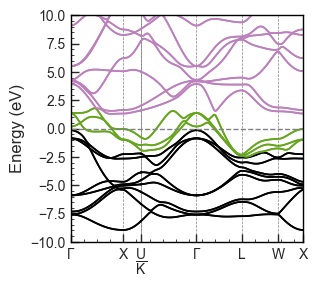

In [26]:
matador.plotting.plot_spectral(
    'HarperCuPData/Ir2P/Ir2P-OQMD_30622-CollCode640898',
    plot_dos=False,
    filename="Ir2P_SOC_BS",
    figsize=(3, 3),
    pdf=True
)

Unable to create spglib structure from input data: skipping path labels: Unable to use doc2spg, one of ('lattice_cart', 'positions_frac', 'atom_types') was missing..


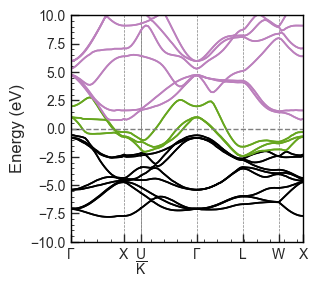

In [27]:
matador.plotting.plot_spectral(
    'HarperCuPData/Rh2P/PRh2-OQMD_7002-CollCode38356',
    plot_dos=False,
    filename="Rh2P_SOC_BS",
    figsize=(3, 3),
    pdf=True
)

### Finite temperature calculations

#### SCAN vs. PBE+MBD Vibrational Free energies

In [28]:
# plot temperature vs. enthalpy for P and P_SCAN
P = VibrationalDOS(castep2dict('HarperCuPData/PPhonon/P-CollCode150873-PBE.castep', db=False)[0])
P_SCAN = VibrationalDOS(castep2dict('HarperCuPData/PPhonon/P-CollCode150873-SCAN.castep', db=False)[0])

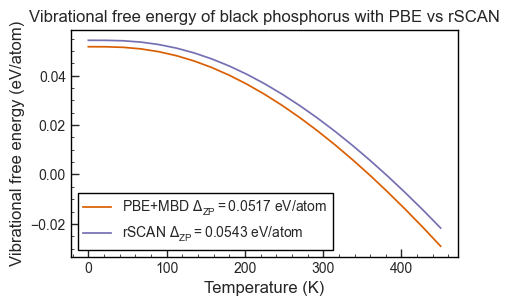

In [29]:
import numpy as np
temperatures = np.linspace(0, 450, 21)
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_title('Vibrational free energy of black phosphorus with PBE vs rSCAN')
P.plot_free_energy(
    temperatures=temperatures, 
    ax=ax, 
    line_kwargs={'label': f'PBE+MBD $\\Delta_{{ZP}}={P.zpe:.4f}$ eV/atom','color':'#d95f02'}
)
P_SCAN.plot_free_energy(
    temperatures=temperatures, 
    ax=ax, 
    line_kwargs={'label': f'rSCAN $\\Delta_{{ZP}}={P_SCAN.zpe:.4f}$ eV/atom','color':'#7570b3'}
)
ax.legend(loc='lower left')
plt.savefig('SCAN_PBE_compare.pdf', bbox_inches='tight')